In [1]:
%pylab inline
from numba import njit
import seaborn as sns
from timeit import default_timer as timer

Populating the interactive namespace from numpy and matplotlib


# Task 14
## Subtask 2: Numba is used
## Subtask 3: Acceleration using numba achieved
## My implementation With JIT

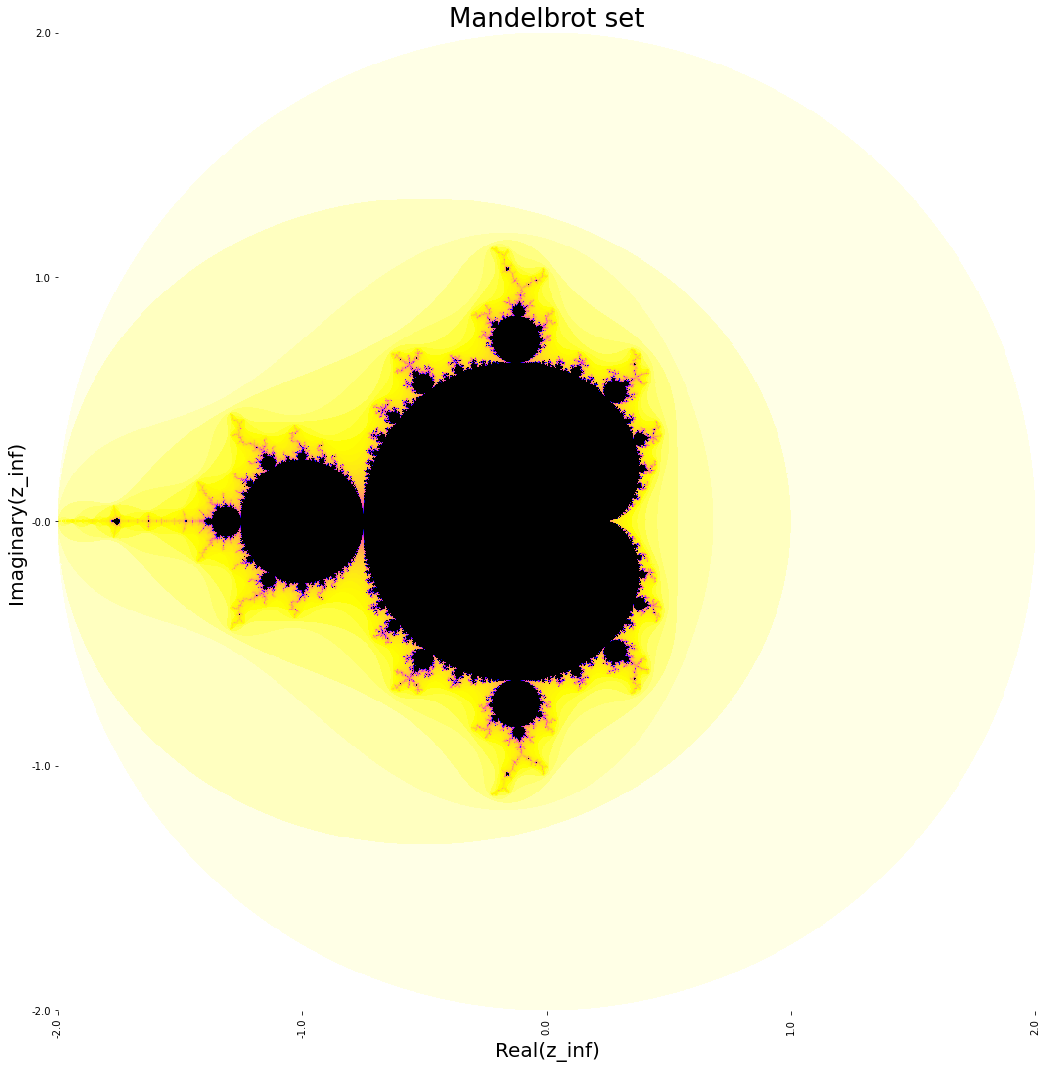

In [2]:
@njit(fastmath=True)
def count(size, pixels, max_iterations, infinity_border):
    
    minRe, maxRe, minIm, maxIm = -size, size, -size, size
    pointsRe, pointsIm = pixels, pixels
    max_iterations = max_iterations
    infinity_border = infinity_border
    
    image = np.zeros((pointsRe, pointsIm)) # image with black colors
    
    # for each complex value (pixel on Re, Im complex plane)
    for ip, Re in enumerate(np.linspace(minRe, maxRe, pointsRe)): # this axis goes down
        for iq, Im in enumerate(np.linspace(minIm, maxIm, pointsIm)): # this axis goes right
            z0 = 0
            c = complex(Re, Im) # consider current z0
            
            # do iterations (default color - black = 0)
            # image[ip, iq] = 0 (black)
            for k in range(max_iterations):
                # calculate current z0
                z0 = z0 ** 2 + c
                
                # if z0 highet than infinity_border
                if abs(z0) >= infinity_border:
                    # set colour of pixel:
                    # less k => fast growth, higher k => slow growth
                    # => k = 0 - white, k = max_iterations - black
                    image[ip, iq] =  max_iterations - k
                    break
    return image

def juliaSetRainbow(size = 1.6, pixels = 100, max_iterations = 100, infinity_border = 300):
    
    image = np.rot90(count(size, pixels, max_iterations, infinity_border))
    fig = plt.figure(figsize=(18, 18))
    sns.heatmap(image, vmin=0, vmax=max_iterations, center= max_iterations/2, cmap= 'gnuplot2', cbar=False, square=True,
                # cbar_kws= {'orientation': 'vertical'}
               )   
    plt.title('Mandelbrot set', fontsize=26)
    plt.ylabel('Imaginary(z_inf)', fontsize=20)
    plt.xlabel('Real(z_inf)', fontsize=20)
    plt.xticks(np.linspace(0, pixels-1, 5), np.round(np.linspace(-size, size, 5),2))
    plt.yticks(np.linspace(0, pixels-1, 5), -np.round(np.linspace(-size, size, 5),2))
    return image
    
image = juliaSetRainbow(size = 2, pixels = 1000, max_iterations = 100, infinity_border = 2)

# My implementation Without JIT

In [3]:
def count(size, pixels, max_iterations, infinity_border):
    
    minRe, maxRe, minIm, maxIm = -size, size, -size, size
    pointsRe, pointsIm = pixels, pixels
    max_iterations = max_iterations
    infinity_border = infinity_border
    
    image = np.zeros((pointsRe, pointsIm)) # image with black colors
    
    # for each complex value (pixel on Re, Im complex plane)
    for ip, Re in enumerate(np.linspace(minRe, maxRe, pointsRe)): # this axis goes down
        for iq, Im in enumerate(np.linspace(minIm, maxIm, pointsIm)): # this axis goes right
            z0 = 0
            c = complex(Re, Im) # consider current z0
            
            # do iterations (default color - black = 0)
            # image[ip, iq] = 0 (black)
            for k in range(max_iterations):
                # calculate current z0
                z0 = z0 ** 2 + c
                
                # if z0 highet than infinity_border
                if abs(z0) >= infinity_border:
                    # set colour of pixel:
                    # less k => fast growth, higher k => slow growth
                    # => k = 0 - white, k = max_iterations - black
                    image[ip, iq] =  max_iterations - k
                    break
    return image

def juliaSetRainbow(size = 1.6, pixels = 100, max_iterations = 100, infinity_border = 300):
    
    image = np.rot90(count(size, pixels, max_iterations, infinity_border))
    fig = plt.figure(figsize=(14, 11))
    sns.heatmap(image, vmin=0, vmax=max_iterations, center= max_iterations/2, cmap= 'gnuplot2', cbar=False, square=True,
                # cbar_kws= {'orientation': 'vertical'}
               )   
    # plt.title('С = exp(i*' + str(np.round(a_val,3)) + ')', fontsize=20)
    plt.ylabel('Imaginary(z_inf)', fontsize=20)
    plt.xlabel('Real(z_inf)', fontsize=20)
    plt.xticks(np.linspace(0, pixels-1, 5), np.round(np.linspace(-size, size, 5),2))
    plt.yticks(np.linspace(0, pixels-1, 5), -np.round(np.linspace(-size, size, 5),2))
    plt.close(fig)

    return image
    
%timeit image = juliaSetRainbow(size = 2, pixels = 1000, max_iterations = 100, infinity_border = 2)

3.5 s ± 89.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### proposed implementation With JIT (from the lecture)

In [4]:
@njit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@njit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

def create_image():
    image = np.zeros((1000, 1000), dtype=np.uint8)
    image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 100)
    return image

%timeit image = create_image()

104 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### proposed implementation Without JIT (from the lecture)

In [5]:
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

#@njit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

def create_image():
    image = np.zeros((1000, 1000), dtype=np.uint8)
    image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 100)
    return image

%timeit image = create_image()

6.68 s ± 96.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Proposed code profiling

## Subtask 1: Mandelbrot code is profiled

In [6]:
@njit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@njit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

def create_image():
    image = np.zeros((1000, 1000), dtype=np.uint8)
    image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 100)
    return image

image = create_image()

In [7]:
%load_ext snakeviz
%snakeviz create_image()

 
*** Profile stats marshalled to file '/tmp/tmpycbg5c1a'. 
Embedding SnakeViz in this document...


## Subtask 4: Measuring computation time - number of total iterations vs computational time (JITed, regular)
### Without JIT

In [ ]:
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

#@njit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

def create_image(max_iters):
    image = np.zeros((500, 500), dtype=np.uint8)
    image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, iters = max_iters)
    return image

times = []
for max_iters in range(10, 300,10):
    s = timer()
    image = create_image(max_iters = max_iters)
    e = timer()
    time = (e - s)*1000
    print(time, 'mSec')
    times.append(time)

418.0478650087025 mSec
601.9846419949317 mSec
745.5207460006932 mSec
904.2349280061899 mSec
1022.5889419962186 mSec
1146.3015000044834 mSec
1282.00391199789 mSec
1426.3983440032462 mSec
1566.7867190059042 mSec
1649.5269739971263 mSec
1743.3562590013025 mSec
1867.2236669954145 mSec
2005.5640280043008 mSec
2111.425965995295 mSec
2244.4376530038426 mSec
2399.8519540036796 mSec
2597.142864993657 mSec
2761.3624350051396 mSec


In [ ]:
plt.figure(figsize=(12, 4))
plt.title('Number of total iterations vs computational time', fontsize=16)
plt.plot(times)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Computational time, mSec", fontsize=14)
plt.xticks(np.arange(0, len(times)), np.arange(1, len(times)+1),  fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

### With JIT

In [ ]:
@njit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@njit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

@njit
def create_image(max_iters):
    image = np.zeros((500, 500), dtype=np.uint8)
    image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, iters = max_iters)
    return image

times = []
for max_iters in range(10, 300,10):
    s = 0
    s = timer()
    image = create_image(max_iters = max_iters)
    e = timer()
    time = (e - s)*1000
    print(time, 'mSec')
    times.append(time)

In [ ]:
plt.figure(figsize=(12, 4))
plt.title('Number of total iterations vs computational time', fontsize=16)
plt.plot(times)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Computational time, mSec", fontsize=14)
plt.xticks(np.arange(0, len(times)), np.arange(1, len(times)+1),  fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()